In [1]:
using Revise

using RigidBodyDynamics
using RigidBodyDynamics: Bounds

using DrakeVisualizer
using Plots
using RigidBodyTreeInspector

using BilevelTrajOpt
gr(size=(500,500), html_output_format=:png);

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9dd84cf97c4fc16956f39829c81f3b6907c8fc83-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Recompiling stale cache file /home/blandry/.julia/lib/v0.6/RigidBodyTreeInspector.ji for module RigidBodyTreeInspector.


In [3]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= Bounds(-100, 100)
velocity_bounds(floatingjoint) .= Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [4]:
q0 = [1., 0., 0., 0., 0., 0., 0.0025]
v0 = [0., 0., 0., .25, 0. , 0.]
N = 15

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)

ctrl! = (u,t,x) -> u[:] = 0.

println("Explicit Contacts")
traj_exp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=false);
println("Implicit Contacts")
traj_imp = BilevelTrajOpt.simulate(x0,env,Δt,N,ctrl!,implicit_contact=true);

Explicit Contacts

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Solve_Succeeded
Implicit Contacts
elapsed time: 53.339251463 seconds
elapsed time: 0.359123512 seconds
elapsed time: 0.353729973 seconds
elapsed time: 0.347897951 seconds
elapsed time: 0.345446128 seconds
elapsed time: 0.349317191 seconds
elapsed time: 0.34382285 seconds
elapsed time: 0.354669681 seconds
elapsed time: 0.343279868 seconds
Solve_Succeeded
elapsed time: 

elapsed time: 0.341369403 seconds
elapsed time: 0.346782579 seconds
elapsed time: 0.342228918 seconds
elapsed time: 0.343760891 seconds
elapsed time: 0.342441062 seconds
elapsed time: 0.347709591 seconds
elapsed time: 0.379961462 seconds
elapsed time: 0.340487345 seconds
elapsed time: 0.358259146 seconds
elapsed time: 0.363734399 seconds
elapsed time: 0.348173453 seconds
elapsed time: 0.373000072 seconds
elapsed time: 0.359290358 seconds
Solve_Succeeded
elapsed time: 0.394123778 seconds
elapsed time: 0.36205258 seconds
elapsed time: 0.361382186 seconds
elapsed time: 0.36782028 seconds
elapsed time: 0.352976258 seconds
elapsed time: 0.346576074 seconds
elapsed time: 0.358848968 seconds
elapsed time: 0.362754015 seconds
elapsed time: 0.349684397 seconds
elapsed time: 0.324697093 seconds
elapsed time: 0.340698216 seconds
elapsed time: 0.397546327 seconds
elapsed time: 0.36136875 seconds
elapsed time: 0.351681034 seconds
elapsed time: 0.358018968 seconds
elapsed time: 0.343948607 seconds
e

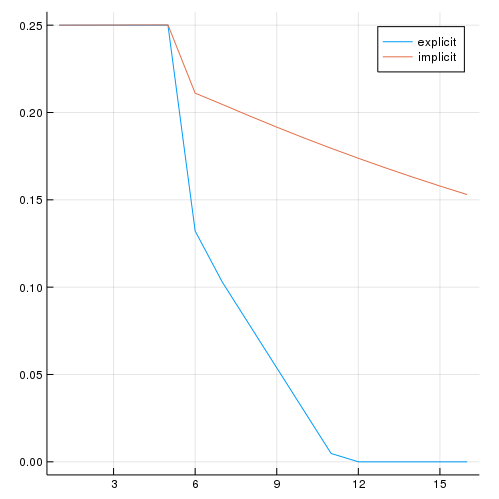

In [5]:
ts = cumsum([Δt for i in 1:N]);
j = 11
plot(traj_exp[j,:],label="explicit")
plot!(traj_imp[j,:],label="implicit")